# PROJECT-1. Угадай знаменитость
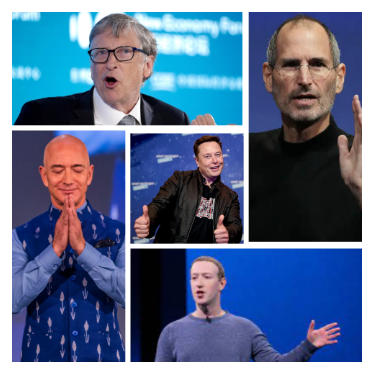 

    Проект позволяет обучить нейронную сеть и угадывать знаменитось по фотографии с accuracy 0.9978 на валидации. 
    Данная сеть умеет узнавать следующих людей:
        * Билл Гейтс
        * Илон Маск
        * Джефф Безос
        * Марк Цукирберг
        * Стив Джопс

In [1]:
%matplotlib inline
%load_ext tensorboard

import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import torchvision
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import random
import numpy as np

from torch.nn import functional as F
# from torch.utils.data import DataLoader
import pytorch_lightning as pl

import warnings
warnings.filterwarnings("ignore")

print(pl.__version__)
print(torch.__version__)
print(torchvision.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(torch.cuda.is_available(), device)

2.4.0
2.4.0+cu118
0.19.0+cu118
True cuda


# Загрузка данных

In [2]:
DATASET_PATH= 'D:\\DataSet\\CV_project1_data'
BATCH_SIZE = 100

In [3]:
fpDataset_train= ImageFolder(os.path.join(DATASET_PATH, 'train'))
fpDataset_valid= ImageFolder(os.path.join(DATASET_PATH, 'valid'))

print(len(fpDataset_train), len(fpDataset_valid))

3000 914


## Визуализация датасета
Посмотрим на несколько примеров из тестовой и валидационной выборок

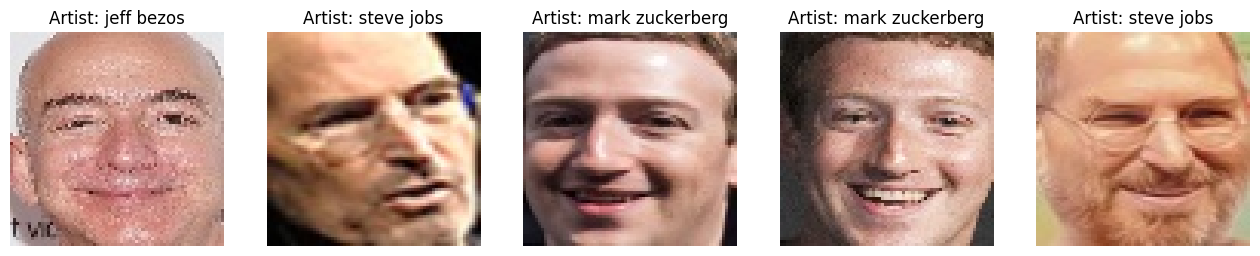

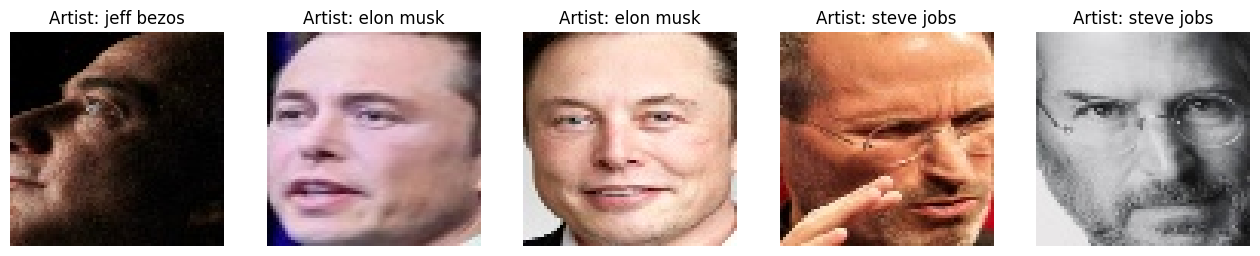

In [4]:
def plot_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 8))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title("Artist: " + random_label.replace("_", " "))
        axes[i].axis("off")

    plt.show()

plot_samples(fpDataset_train)
plot_samples(fpDataset_valid)

## Предобработка данных

    Для хорошей работы модели, необходимо привести данные к виду понятному и знакомому модели.
    Так же для того, чтобы модель меньше переобучалась, добавлю случайые аугментации для тренировочных данных

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

fpDataset_train.transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
fpDataset_valid.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

## Создаю загрузчики

In [6]:
train_loader = torch.utils.data.DataLoader(
    fpDataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), persistent_workers=True
)

valid_loader = torch.utils.data.DataLoader(
    fpDataset_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), persistent_workers=True
)

### Визуализация одного бача из загрузчики
Отобразим один бачь (трансформированных и нормализованных данных)

Классы объектов: tensor([1, 2, 0, 4, 3, 3, 3, 0, 2, 1, 3, 4, 1, 1, 2, 0, 1, 3, 1, 1, 2, 1, 4, 4,
        0, 0, 0, 3, 2, 1, 2, 0, 4, 1, 1, 2, 2, 0, 0, 3, 1, 2, 2, 0, 0, 3, 3, 2,
        0, 2, 2, 2, 1, 2, 4, 2, 0, 1, 1, 2, 4, 3, 2, 4, 4, 0, 4, 1, 2, 3, 3, 0,
        4, 1, 2, 1, 4, 4, 0, 0, 4, 2, 4, 3, 4, 3, 1, 3, 1, 3, 2, 2, 1, 2, 0, 0,
        2, 3, 3, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


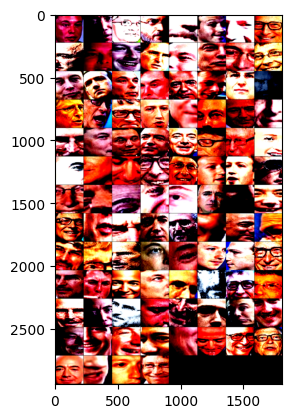

In [7]:
X_train, y_train = next(iter(train_loader))
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))

# classes = train_data.classes
# classes

# print([classes[i] for i in y_train])
print(f'Классы объектов: {y_train}')
plt.imshow(img)

# Обучение модели
    Для классификации знаменитостей я решил выбрать ReseNet34. т.к. эта сеть хорошо показала себя в задаче классификации изоражений и обучена на датасете ImageNet (должна уметь вычленять необходимые признаки из картинок).
    т.к. у нас не очень много данных, начну с обучения классифиатора и буду постепенно продвигаться с конца сети к началу (разблокируя и дообучая слои), пока модель будет обучаться.

In [8]:
class famousPeopleModel(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.lr = 1e-2
        # используем предобученную модель ResNet-34
        self.net = torchvision.models.resnet34(pretrained=True)
        # замораживаем веса
        for parameter in self.net.parameters():
            # ...
            parameter.requires_grad = False
        # заменяем полносвязный слой на новый под нужное количество классов
        self.net.fc = torch.nn.Linear(512, 5)


    # вызов модуля
    def forward(self, x):
        return self.net(x)

    # шаг обучения
    def training_step(self, batch, batch_nb):
        images, target = batch
        output = self(images)
        # используем "функциональную" версию функции потерь вместо инстанцирования модуля
        loss = F.cross_entropy(output, target)
        with torch.no_grad():
            top1 = torch.mean((output.argmax(1) == target).float()).item()

        # логируем метрики — они будут как в прогрессбаре внизу, так и в отдельной директории
        self.log('loss/train', loss, on_step=False, on_epoch=True)
        self.log('top1/train', top1, on_step=False, on_epoch=True, prog_bar=True)

        # нужно вернуть основное значение лосса (функции потерь)
        return loss

    def validation_step(self, batch, batch_idx):
        images, target = batch
        with torch.no_grad():
            output = self(images)
            loss = F.cross_entropy(output, target)
            top1 = torch.mean((output.argmax(1) == target).float()).item()

        self.log('loss/val', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('top1/val', top1, on_step=False, on_epoch=True, prog_bar=True)

    # используемые оптимизаторы
    def configure_optimizers(self):
        # return torch.optim.SGD(self.net.parameters(), lr=1e-2, weight_decay=1e-3)
        weight_decay = self.lr / 5
        # weight_decay = self.lr / 10
        # return torch.optim.SGD(self.net.parameters(), lr=1e-2, weight_decay=weight_decay)
        return torch.optim.Adam(self.net.parameters(), lr=self.lr, weight_decay=weight_decay)

In [9]:
# Инициализируем модель
famousPeople_model = famousPeopleModel()

famousPeople_model

famousPeopleModel(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [10]:
# Для начала обучу классификатор
famousPeople_model.lr = 1e-2
trainer = pl.Trainer(devices=-1, max_epochs=10, enable_progress_bar=True)
trainer.fit(famousPeople_model, train_loader, valid_loader)
# Дальше понижаю шаг обучения и дообучаю с layer4
famousPeople_model.lr = 5e-3
for parameter in famousPeople_model.net.layer4.parameters():
    parameter.requires_grad = True
trainer = pl.Trainer(devices=-1, max_epochs=10, enable_progress_bar=True)
trainer.fit(famousPeople_model, train_loader, valid_loader)
# Еще немного дообучить
famousPeople_model.lr = 1e-3
trainer = pl.Trainer(devices=-1, max_epochs=10, enable_progress_bar=True)
trainer.fit(famousPeople_model, train_loader, valid_loader)
# И еще немного
famousPeople_model.lr = 1e-4
trainer = pl.Trainer(devices=-1, max_epochs=10, enable_progress_bar=True)
trainer.fit(famousPeople_model, train_loader, valid_loader)
# Расширяю обучение на layer3
famousPeople_model.lr = 1e-4
for parameter in famousPeople_model.net.layer3.parameters():
    parameter.requires_grad = True
trainer = pl.Trainer(devices=-1, max_epochs=10, enable_progress_bar=True)
trainer.fit(famousPeople_model, train_loader, valid_loader)
# Расширяю обучение на layer2
famousPeople_model.lr = 1e-4
for parameter in famousPeople_model.net.layer2.parameters():
    parameter.requires_grad = True
trainer = pl.Trainer(devices=-1, max_epochs=10, enable_progress_bar=True)
trainer.fit(famousPeople_model, train_loader, valid_loader)
# Расширяю обучение на layer1
famousPeople_model.lr = 1e-5
for parameter in famousPeople_model.net.layer1.parameters():
    parameter.requires_grad = True
trainer = pl.Trainer(devices=-1, max_epochs=10, enable_progress_bar=True)
trainer.fit(famousPeople_model, train_loader, valid_loader)

# famousPeople_model.lr = 1e-6
# trainer = pl.Trainer(devices=-1, max_epochs=10, enable_progress_bar=True)
# trainer.fit(famousPeople_model, train_loader, valid_loader)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | net  | ResNet | 21.3 M | train
----------------------------------------
2.6 K     Trainable params
21.3 M    Non-trainable params
21.3 M    Total params
85.149    Total estimated model params size (MB)
116       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 30/30 [00:14<00:00,  2.01it/s, v_num=121, loss/val=0.511, top1/val=0.809, top1/train=0.719]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 30/30 [00:15<00:00,  1.90it/s, v_num=121, loss/val=0.511, top1/val=0.809, top1/train=0.719]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | net  | ResNet | 21.3 M | train
----------------------------------------
13.1 M    Trainable params
8.2 M     Non-trainable params
21.3 M    Total params
85.149    Total estimated model params size (MB)
116       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 30/30 [00:16<00:00,  1.82it/s, v_num=122, loss/val=0.348, top1/val=0.880, top1/train=0.892]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 30/30 [00:18<00:00,  1.61it/s, v_num=122, loss/val=0.348, top1/val=0.880, top1/train=0.892]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | net  | ResNet | 21.3 M | train
----------------------------------------
13.1 M    Trainable params
8.2 M     Non-trainable params
21.3 M    Total params
85.149    Total estimated model params size (MB)
116       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 30/30 [00:16<00:00,  1.85it/s, v_num=123, loss/val=0.0586, top1/val=0.982, top1/train=0.940]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 30/30 [00:18<00:00,  1.62it/s, v_num=123, loss/val=0.0586, top1/val=0.982, top1/train=0.940]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | net  | ResNet | 21.3 M | train
----------------------------------------
13.1 M    Trainable params
8.2 M     Non-trainable params
21.3 M    Total params
85.149    Total estimated model params size (MB)
116       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 30/30 [00:17<00:00,  1.75it/s, v_num=124, loss/val=0.0274, top1/val=0.992, top1/train=0.960]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 30/30 [00:19<00:00,  1.57it/s, v_num=124, loss/val=0.0274, top1/val=0.992, top1/train=0.960]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | net  | ResNet | 21.3 M | train
----------------------------------------
19.9 M    Trainable params
1.3 M     Non-trainable params
21.3 M    Total params
85.149    Total estimated model params size (MB)
116       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 30/30 [00:19<00:00,  1.58it/s, v_num=125, loss/val=0.0413, top1/val=0.988, top1/train=0.970]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 30/30 [00:22<00:00,  1.35it/s, v_num=125, loss/val=0.0413, top1/val=0.988, top1/train=0.970]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | net  | ResNet | 21.3 M | train
----------------------------------------
21.1 M    Trainable params
231 K     Non-trainable params
21.3 M    Total params
85.149    Total estimated model params size (MB)
116       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 30/30 [00:19<00:00,  1.55it/s, v_num=126, loss/val=0.0187, top1/val=0.996, top1/train=0.975]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 30/30 [00:22<00:00,  1.33it/s, v_num=126, loss/val=0.0187, top1/val=0.996, top1/train=0.975]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | net  | ResNet | 21.3 M | train
----------------------------------------
21.3 M    Trainable params
9.5 K     Non-trainable params
21.3 M    Total params
85.149    Total estimated model params size (MB)
116       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 30/30 [00:21<00:00,  1.41it/s, v_num=127, loss/val=0.0169, top1/val=0.997, top1/train=0.985]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 30/30 [00:24<00:00,  1.23it/s, v_num=127, loss/val=0.0169, top1/val=0.997, top1/train=0.985]


В сумме получилось 70 эпох

## Визуализация процесса обучения

In [11]:
%load_ext tensorboard
# %tensorboard --logdir './lightning_logs'
%tensorboard --logdir='D:/Python/SkillFactory_CV/PROJECT-1. Угадай знаменитость/lightning_logs' --port 5006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Итоговый результат
В конце 80 эпохи, модель перестала улучшать показатели на валидации и достагла стабильного Accuracy **0.9978**

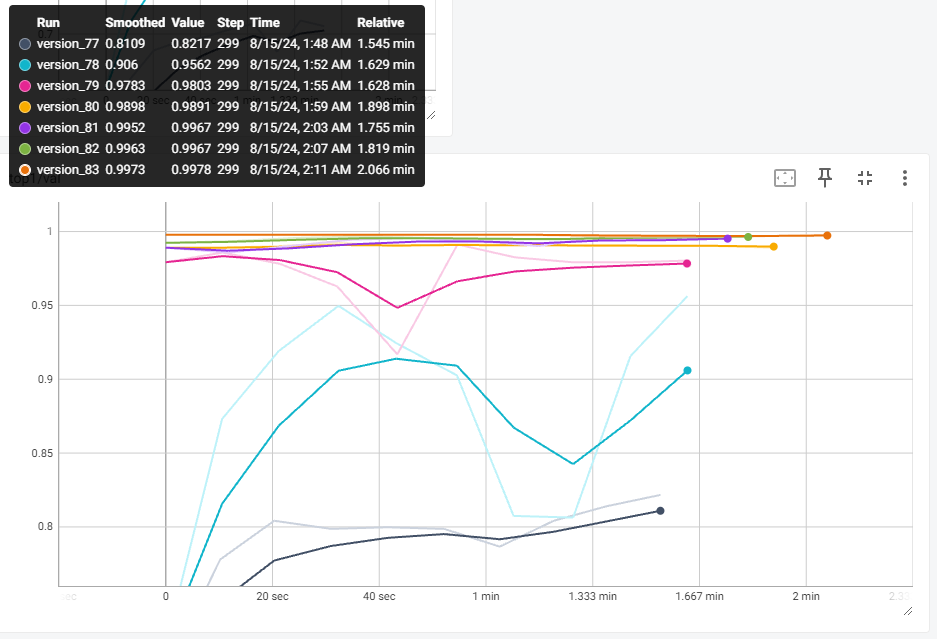

## Предсказания модели
Пример трансформированных валидационных даных и их классов

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6155462..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6998693..1.8892884].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9656862..2.64].


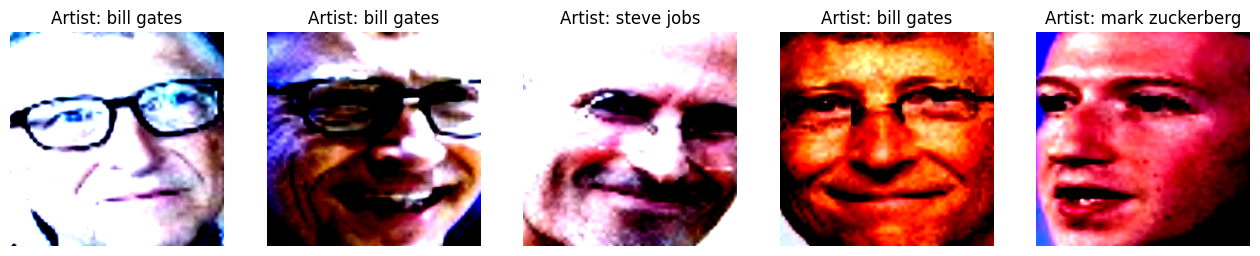

In [15]:
def plot_samples_predict(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 8))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image.numpy().transpose((1,2,0)))
        axes[i].set_title("Artist: " + random_label.replace("_", " "))
        axes[i].axis("off")

    plt.show()

plot_samples_predict(fpDataset_valid, 5)

### Предскажем класс на изображении не из выборки
    Далее я тестирую классификационную силу модели, по разному подавая в нее данные (тестовый датасет)

In [43]:
from PIL import Image

TEST_FOLDER = './test/Steve_jobs/'

image = Image.open(TEST_FOLDER + "02.jpg")

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(image)

tensor = fpDataset_valid.transform(image)
batch = torch.stack([tensor])
with torch.no_grad():
    output = famousPeople_model(batch.to("cpu")).to("cpu")

predicted = output.argmax().item()
print(f"Predict:{fpDataset_valid.classes[predicted]}  tenzor:{output}")
fpDataset_valid.classes[predicted]

SyntaxError: invalid syntax (454859754.py, line 16)

## Предсказываю для всех изображений по одному
Для каждого ихображения создается свой батч

17
tensor([[ 0.7930,  1.1584, -0.0016, -0.7760, -1.0216]]) 1 elon_musk
tensor([[ 0.7353,  0.9083, -0.0137, -0.7639, -0.7183]]) 1 elon_musk
tensor([[ 0.5610,  1.3070,  0.2059, -0.8535, -1.1566]]) 1 elon_musk
tensor([[ 0.4209,  0.9491,  0.1257, -0.4348, -0.8770]]) 1 elon_musk
tensor([[ 0.6108,  1.0704, -0.1647, -0.5006, -0.9326]]) 1 elon_musk
tensor([[ 0.7357,  1.3036,  0.1111, -0.4591, -1.5794]]) 1 elon_musk
tensor([[ 0.4769,  1.5704, -0.0920, -0.5306, -1.3309]]) 1 elon_musk
tensor([[ 0.6573,  1.3191,  0.0544, -0.5746, -1.3287]]) 1 elon_musk
tensor([[ 0.8718,  1.0409,  0.2482, -0.6245, -1.3012]]) 1 elon_musk
tensor([[ 0.8891,  1.2797,  0.0715, -1.0799, -1.1371]]) 1 elon_musk
tensor([[ 0.8685,  0.8656,  0.0534, -0.3702, -1.2557]]) 0 bill_gates
tensor([[ 0.4131,  1.0624,  0.2224, -0.7617, -0.7032]]) 1 elon_musk
tensor([[ 0.5219,  1.1126,  0.1311, -0.3879, -1.2426]]) 1 elon_musk
tensor([[ 0.1840,  1.4492,  0.1882, -0.5850, -1.1572]]) 1 elon_musk
tensor([[ 0.4060,  1.3747, -0.0286, -0.7361,

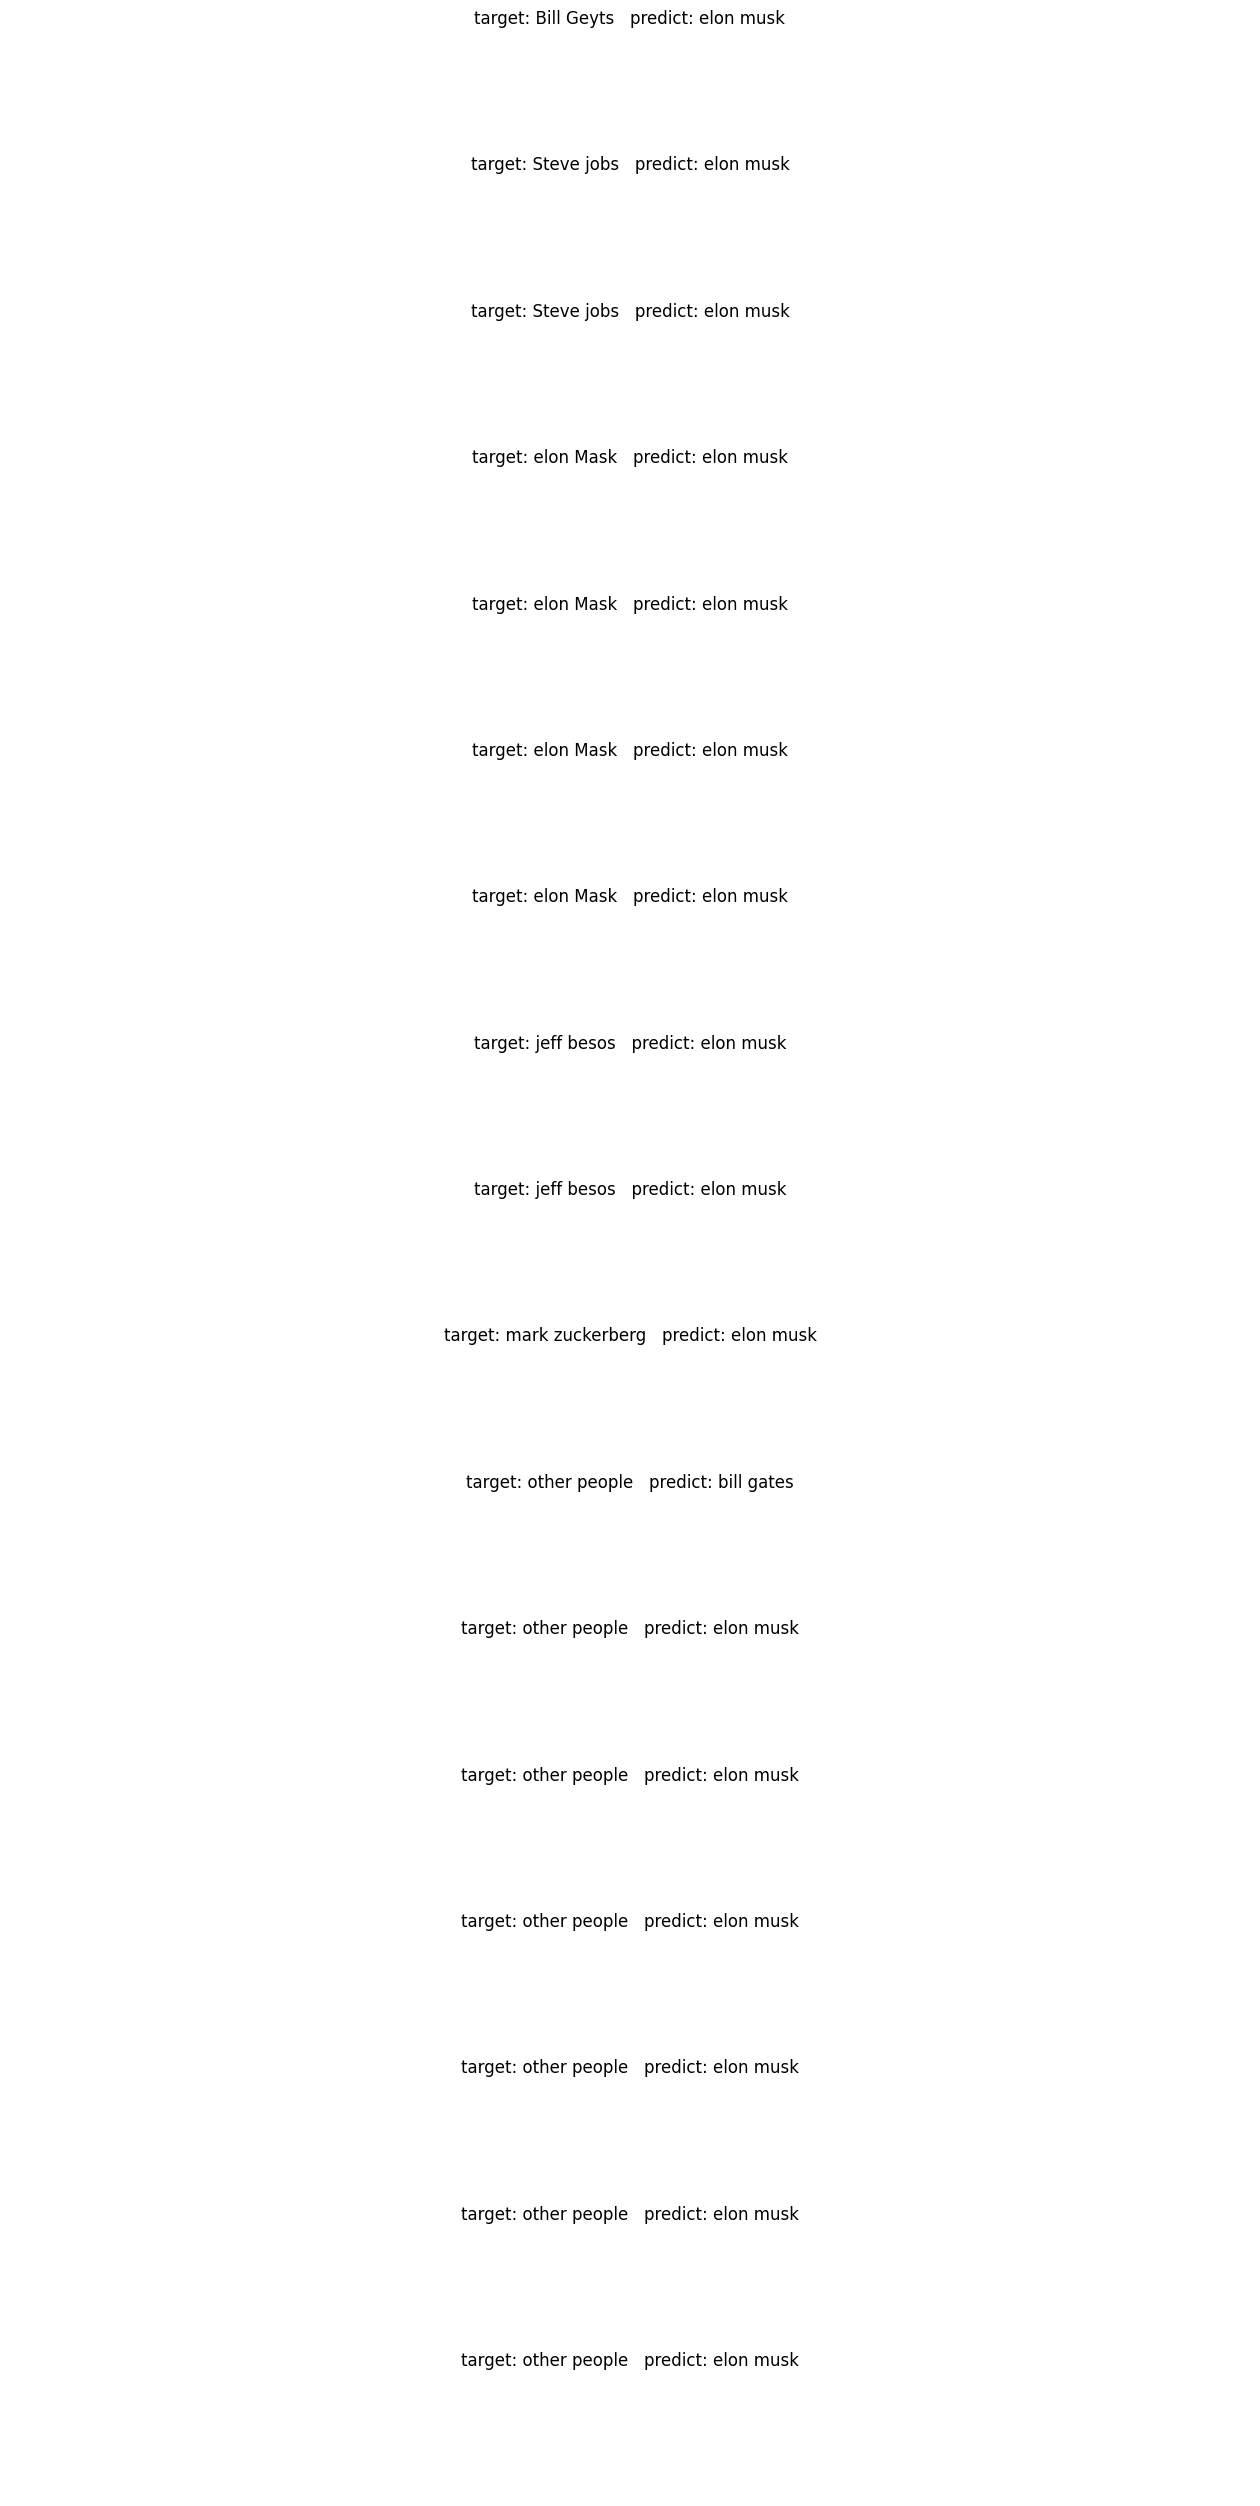

In [40]:
from PIL import Image

# TEST_FOLDER = './test/Elon_Mask/'
fpDataset_test= ImageFolder('./test')
fpDataset_test.transform = fpDataset_valid.transform

print(len(fpDataset_test))
fig, axes = plt.subplots(len(fpDataset_test), 1, figsize=(16, 32))

for i, (image, target) in enumerate(fpDataset_test):

    # image = Image.open(TEST_FOLDER + "04.jpg")

    # fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    # axes[i].imshow(image)
    # axes[i].imshow(image.numpy().transpose((1,2,0)))

    # tensor = fpDataset_valid.transform(image)
    # batch = torch.stack([tensor])
    batch = torch.stack([image])
    with torch.no_grad():
        output = famousPeople_model(batch.to("cpu")).to("cpu")

    predicted = output.argmax().item()
    print(output, predicted, fpDataset_valid.classes[predicted])
    # fpDataset_valid.classes[predicted]

    target_label = fpDataset_test.classes[target]
    predict_label = fpDataset_valid.classes[predicted]

    axes[i].set_title(f"target: {target_label.replace('_', ' ')}   predict: {predict_label.replace('_', ' ')}")
    axes[i].axis('off')

## Предскажем для всех элементов TEST датасета
Создаю загрузчик для тестовых данных

In [20]:
fpDataset_test= ImageFolder('./test')

print(len(fpDataset_test))

17


Создаю DataLoader и помещаю все изображения в один батч. И чтобы убедиться, что все работает, вывожу предсказания.

In [31]:
fpDataset_test.transform = fpDataset_valid.transform

test_loader = torch.utils.data.DataLoader(
    fpDataset_test, batch_size=len(fpDataset_test), shuffle=False, num_workers=os.cpu_count(), persistent_workers=True
)

X_test, y_test = next(iter(test_loader))

with torch.no_grad():
    output = famousPeople_model(X_test.to("cpu")).to("cpu")

# predicted = ...
predicted = output.argmax(axis=1)
# fpDataset_valid.classes[predicted]
for i, el in enumerate(predicted):
    print(f"Target:{fpDataset_test.classes[y_test[i]]}     Predict:{fpDataset_valid.classes[el]}")

Target:Bill_Geyts     Predict:bill_gates
Target:Steve_jobs     Predict:mark_zuckerberg
Target:Steve_jobs     Predict:steve_jobs
Target:elon_Mask     Predict:mark_zuckerberg
Target:elon_Mask     Predict:steve_jobs
Target:elon_Mask     Predict:elon_musk
Target:elon_Mask     Predict:elon_musk
Target:jeff_besos     Predict:jeff_bezos
Target:jeff_besos     Predict:jeff_bezos
Target:mark_zuckerberg     Predict:mark_zuckerberg
Target:other_people     Predict:bill_gates
Target:other_people     Predict:steve_jobs
Target:other_people     Predict:bill_gates
Target:other_people     Predict:elon_musk
Target:other_people     Predict:elon_musk
Target:other_people     Predict:jeff_bezos
Target:other_people     Predict:mark_zuckerberg


Добавлю визуализацию предсказаний.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1519828].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9428324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.622571].
Clipp

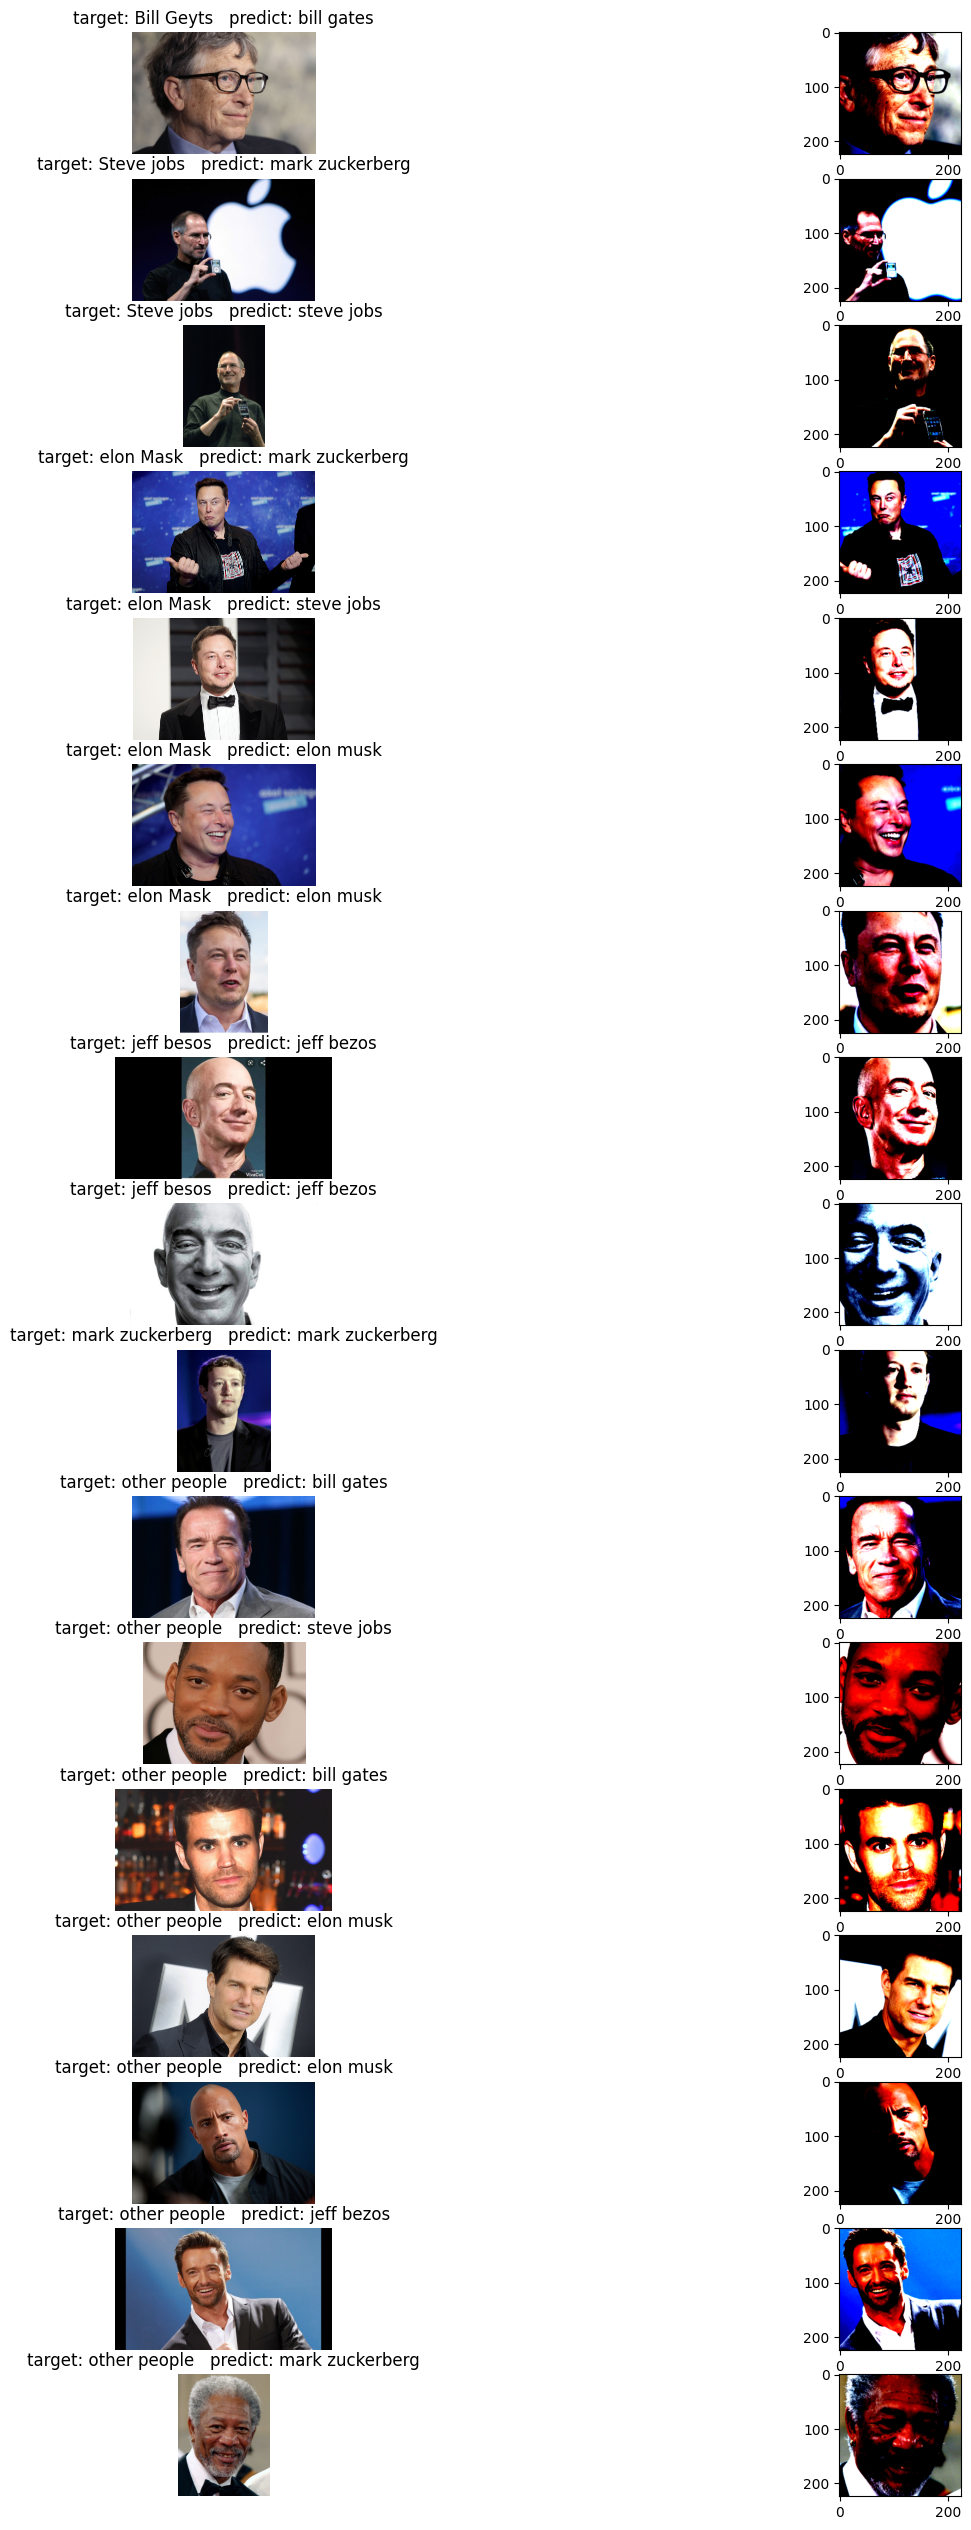

In [33]:
image_f = ImageFolder('./test')

fig, axes = plt.subplots(len(image_f), 2, figsize=(16, 32))

for i, (image, target) in enumerate(image_f):
    # random_image, random_class = random.choice(dataset)
    # random_image = image_f[i]
    target_label = image_f.classes[target]
    predict_label = fpDataset_valid.classes[predicted[i]]
    # print(image)
    axes[i][0].imshow(image)
    axes[i][0].set_title(f"target: {target_label.replace('_', ' ')}   predict: {predict_label.replace('_', ' ')}")
    axes[i][0].axis('off')
    # т.к. получаю плохие предсказания, решил дополнительно посмотерь на чеем предсказывает сеть
    axes[i][1].imshow(X_test[i].numpy().transpose((1,2,0)))


plt.show()   

## Результаты
В ходе проекта модель на основе resenet34 научилась угадывать предложенных снаменитостей по фотографии.